In [2]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import time
import pickle
import os
#import matplotlib.pyplot as plt
from  data.pathsandmore import pathname
from functions import viz_per_time_period

DATA_LOCATION='https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data'

crashes=pd.read_csv(pathname,dtype={'ZIP CODE': str},
                   parse_dates=["CRASH DATE"])
#fixing columns names
crashes.columns=[col.replace(' ','_').lower() for col in crashes.columns]
crashes.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2021-09-11,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2022-06-29,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,2021-09-11,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,2021-12-14,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [3]:
#fixing columns names
crashes.columns=[col.replace(' ','_').lower() for col in crashes.columns]
#checking time
max_hour=max([int(x.split(':')[0]) for x in crashes.crash_time])
min_hour=min([int(x.split(':')[0]) for x in crashes.crash_time])
print(f"the latest hour is {max_hour} and the earliest one is {min_hour}")
crashes['hour']=[int(x.split(':')[0]) for x in crashes.crash_time]
max_minute=max([int(x.split(':')[1]) for x in crashes.crash_time])
min_minute=min([int(x.split(':')[1]) for x in crashes.crash_time])
print(f"the latest hour is {max_minute} and the earliest one is {min_minute}")
crashes['weekday']=crashes.crash_date.dt.day_name()
crashes['weekday']=[day[:3] for day in crashes.weekday]
crashes['month']=crashes.crash_date.dt.month_name()
crashes['month']=[month[:3] for month in crashes.month]
crashes['year']=crashes['crash_date'].dt.year
print(f"The first day of this dataset is {crashes.crash_date.min()}")
print(f"The last day of this dataset is {crashes.crash_date.max()}")
##making it up to end of year 2023
crashes=crashes[(crashes.crash_date>'2012-12-31') &(crashes.crash_date<'2024-01-01')]
crashes.to_csv('./data/crashesupto2023.csv',index=False)

the latest hour is 23 and the earliest one is 0
the latest hour is 59 and the earliest one is 0
The first day of this dataset is 2012-07-01 00:00:00
The last day of this dataset is 2024-11-30 00:00:00


In [4]:
nulls_in_boroughs=crashes[(crashes.borough.isnull()) & (crashes.latitude.notnull())].shape[0]
print(f"These are the number of nulls in borough but that I have lat and long: {nulls_in_boroughs}")

These are the number of nulls in borough but that I have lat and long: 435950


In [5]:
crashes.isnull().sum()

crash_date                             0
crash_time                             0
borough                           616592
zip_code                          616840
latitude                          217370
longitude                         217370
location                          217370
on_street_name                    420656
cross_street_name                 759943
off_street_name                  1615402
number_of_persons_injured             18
number_of_persons_killed              31
number_of_pedestrians_injured          0
number_of_pedestrians_killed           0
number_of_cyclist_injured              0
number_of_cyclist_killed               0
number_of_motorist_injured             0
number_of_motorist_killed              0
contributing_factor_vehicle_1       6656
contributing_factor_vehicle_2     306140
contributing_factor_vehicle_3    1815578
contributing_factor_vehicle_4    1923712
contributing_factor_vehicle_5    1946747
collision_id                           0
vehicle_type_cod

<a id="top"></a>
## Temporal Analysis
> the following cells will go over the analysis of the crashes in NYC by different temporal periods.
1. [Year.](#year)
2. [Months.](#months)
3. [Weekdays.](#weekdays)
4. [Hours.](#hours)

<a id="year"></a>

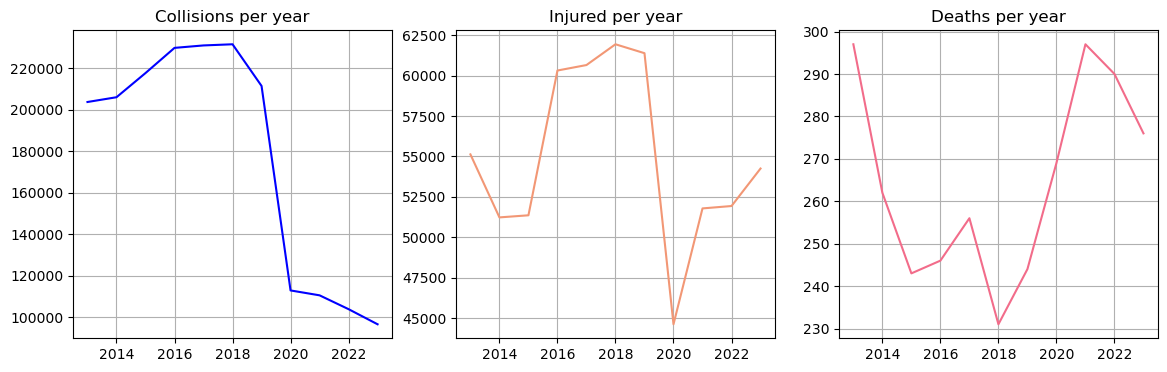

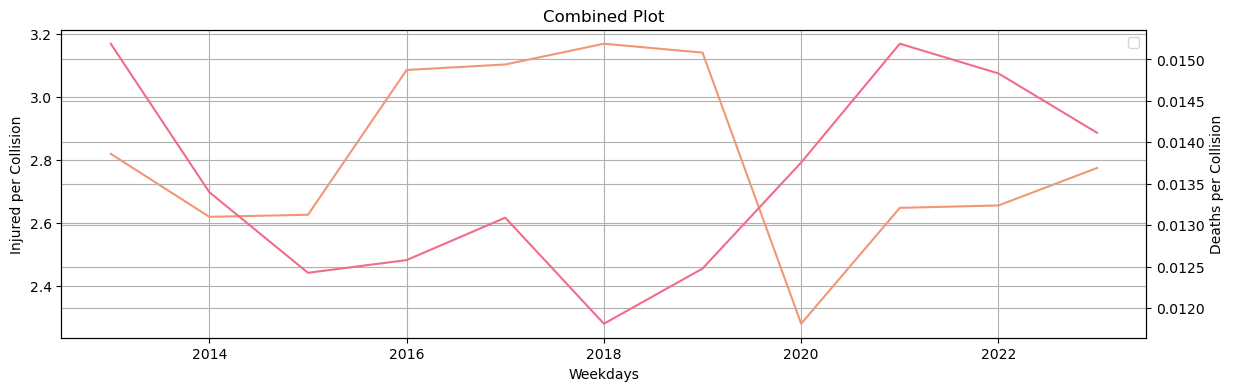

In [6]:
min_=min(crashes.year)
max_=max(crashes.year)
years_list=list(range(min_,max_+1))
viz_per_time_period(crashes, 'year', years_list)

> While the number of collisions and injured when down during 2020 (pandemic effect) it did not happen the same with the deaths.

> It is interesting to see how injured per collision and deaths per collision seem to follow opposite correlation.

In [7]:
 year_groupby=crashes.groupby('year')[['collision_id','number_of_persons_injured','number_of_persons_killed']].\
                        agg({'collision_id':'count',
                             'number_of_persons_injured':'sum',
                             'number_of_persons_killed':'sum'
                             
                                                                        }).reindex(years_list)
year_by_collision=(year_groupby*(100/crashes.shape[0])).iloc[:,1:]
year_by_collision.corr()
##Pretty surprising

,number_of_persons_injured,number_of_persons_killed
number_of_persons_injured,1.000000,-0.514123
number_of_persons_killed,-0.514123,1.000000


<a id="months"></a>

In [13]:
##Correlation is way higher since 2017
year2017on=crashes[crashes.year>=2017].groupby('year')[['collision_id','number_of_persons_injured','number_of_persons_killed']].\
                        agg({'collision_id':'count',
                             'number_of_persons_injured':'sum',
                             'number_of_persons_killed':'sum'
                             
                                                                        }).reindex(years_list)
                                                                        
year_by_collision=(year2017on*(100/crashes[crashes.year>=2017].shape[0])).iloc[:,1:]
year_by_collision.corr()

,number_of_persons_injured,number_of_persons_killed
number_of_persons_injured,1.000000,-0.703487
number_of_persons_killed,-0.703487,1.000000


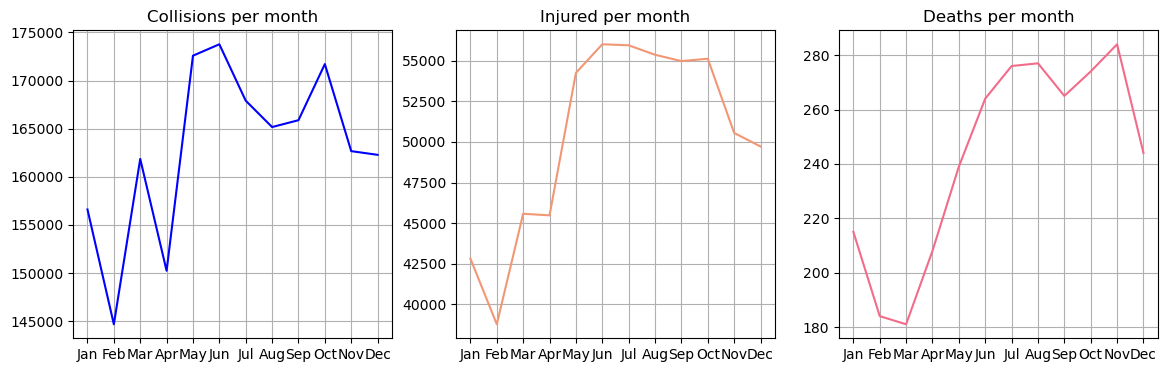

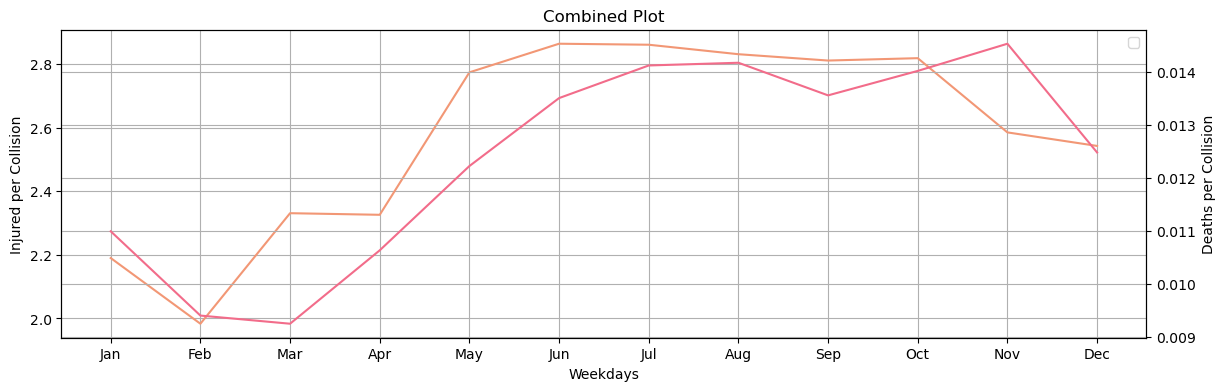

In [8]:
months_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep',\
            'Oct','Nov','Dec']
viz_per_time_period(crashes, 'month', months_list)

> Interesting insight: collisions and injuries peak in June, but the highest number of deaths occurs in November.

> Analysis per collision. Both graphs navigate together, with a significant gap in November, once again.

<a id="weekdays"></a>

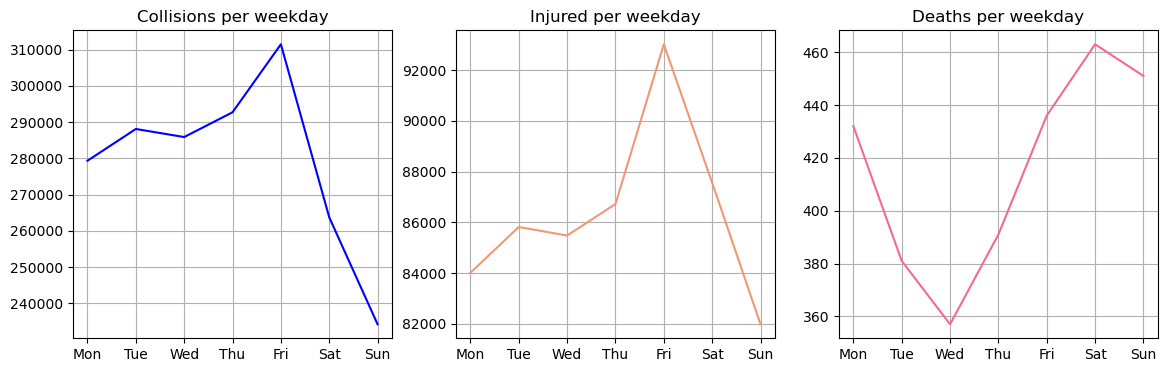

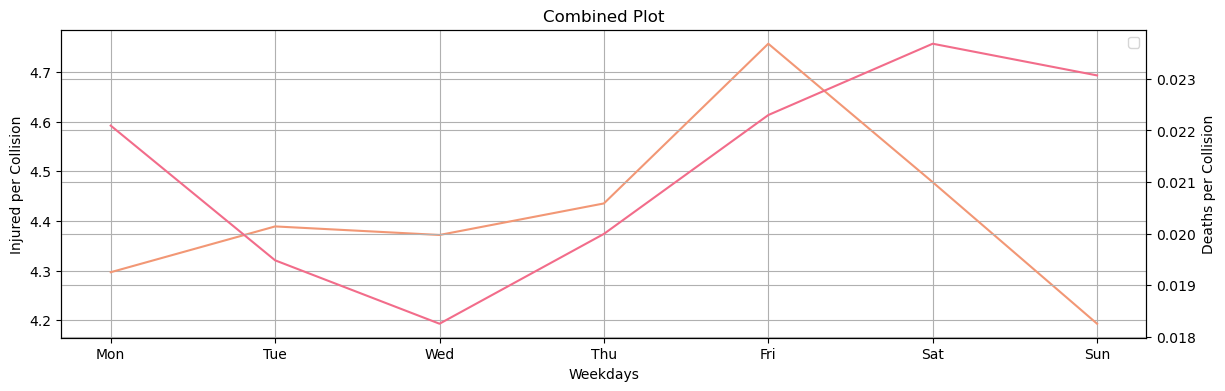

In [9]:
weekdays_list=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
viz_per_time_period(crashes, 'weekday', weekdays_list)

> While the number of deaths have their peak during the weekends it is during the weekdays when most collisions happen.

> Although the higher numbers for deaths/collisions are on Saturday and slightly descend on Sunday, the number of injured by collision has a steep decline on Saturday and Sunday after peaking on Friday

<a id="hours"></a>

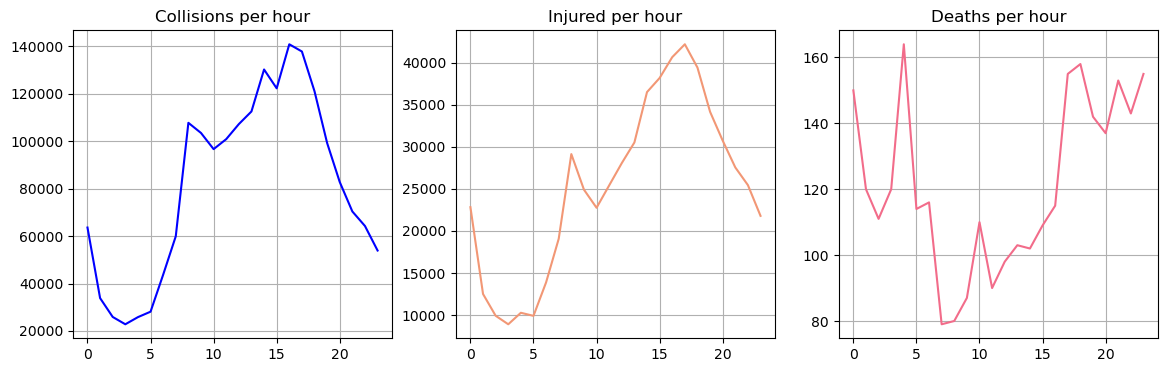

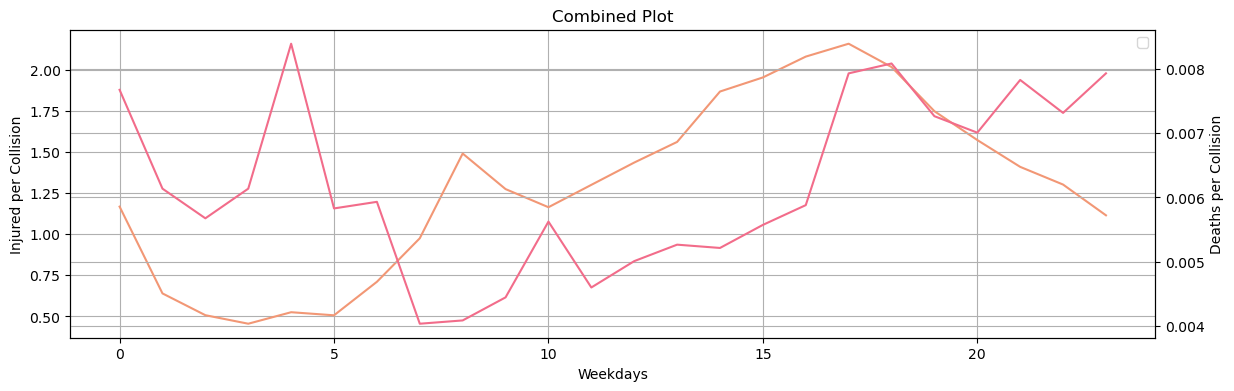

In [14]:
hours_list=list(range(0,25))
viz_per_time_period(crashes, 'hour', hours_list)


> Once again, the number of collisions and the number of injured people move together but not the total deaths which follow a different pattern: a valley during the day and high numbers early and late in the day.

> The viz by collision shows the same: the number of people injured by collision starts declining during afternoon, while the ratio of deaths by collision keeps climbing until early morning.

[return to top](#top)